In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
import zipfile,os

base_dir='/content/drive/MyDrive/Colab Notebooks/datasets/gendermelanes2'
os.listdir(base_dir)

['non_melanesia_male',
 'melanesia_female',
 'melanesia_male',
 'non_melanesia_female']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   shear_range = 0.2, 
                                   horizontal_flip=True, 
                                   fill_mode ='nearest',
                                   validation_split = 0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255, 
                                  zoom_range = 0.2, 
                                  shear_range = 0.2, 
                                  horizontal_flip=True,
                                  fill_mode = 'nearest', 
                                  validation_split = 0.2
                                 )

In [ ]:
train_generator = train_datagen.flow_from_directory(
        base_dir,  
        target_size=(150, 150),  
        shuffle = True,
        subset='training')
     
validation_generator = test_datagen.flow_from_directory(
        base_dir, 
        target_size=(150, 150),  
        subset='validation')

Found 648 images belonging to 4 classes.
Found 161 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(input_shape = (150, 150, 3), weights = "imagenet", include_top = False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras import layers
x = layers.Flatten()(vgg16.output)
prediction = layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs = vgg16.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
class Reminder(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        ACCURACY_THRESHOLD = 0.95
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nTarget reached %2.2f%%. Stop Training" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

reminderCB = Reminder()

In [ ]:
fitting_history = model.fit(
                      train_generator,
                      epochs=20,
                      validation_data=validation_generator, 
                      verbose=1,
                      callbacks = [reminderCB]
                    )

Epoch 1/20
21/21 [==============================] - 553s 27s/step - loss: 1.0907 - accuracy: 0.5031 - val_loss: 0.7710 - val_accuracy: 0.7081
Epoch 2/20
21/21 [==============================] - 261s 13s/step - loss: 0.6460 - accuracy: 0.7114 - val_loss: 0.6515 - val_accuracy: 0.6957
Epoch 3/20
21/21 [==============================] - 259s 13s/step - loss: 0.5059 - accuracy: 0.8040 - val_loss: 0.6396 - val_accuracy: 0.7391
Epoch 4/20
21/21 [==============================] - 260s 13s/step - loss: 0.4491 - accuracy: 0.8395 - val_loss: 0.5535 - val_accuracy: 0.7764
Epoch 5/20
21/21 [==============================] - 261s 13s/step - loss: 0.3813 - accuracy: 0.8796 - val_loss: 0.5376 - val_accuracy: 0.8012
Epoch 6/20
21/21 [==============================] - 260s 13s/step - loss: 0.3701 - accuracy: 0.8719 - val_loss: 0.4961 - val_accuracy: 0.8261
Epoch 7/20
21/21 [==============================] - 258s 13s/step - loss: 0.3108 - accuracy: 0.9090 - val_loss: 0.4755 - val_accuracy: 0.7826
Epoch 

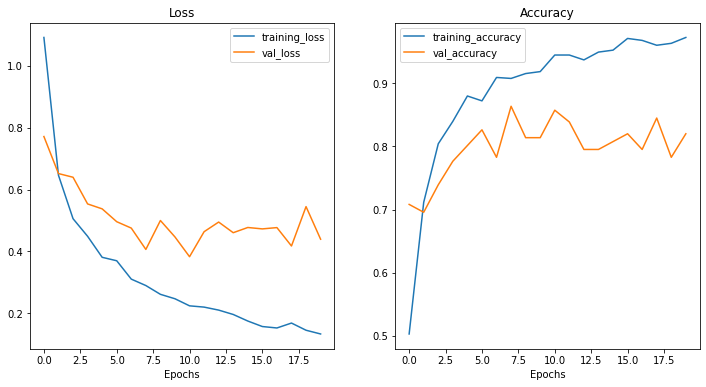

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(fitting_history):
  loss = fitting_history.history['loss']
  val_loss = fitting_history.history['val_loss']

  accuracy = fitting_history.history['accuracy']
  val_accuracy = fitting_history.history['val_accuracy']

  epochs = range(len(fitting_history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(fitting_history)

In [ ]:
model.evaluate(train_generator), model.evaluate(validation_generator)

6/6 [==============================] - 44s 7s/step - loss: 0.4099 - accuracy: 0.8075


([0.12620127201080322, 0.9783950448036194],
 [0.40993550419807434, 0.8074533939361572])

In [ ]:
train_generator.class_indices, validation_generator.class_indices

({'melanesia_female': 0,
  'melanesia_male': 1,
  'non_melanesia_female': 2,
  'non_melanesia_male': 3},
 {'melanesia_female': 0,
  'melanesia_male': 1,
  'non_melanesia_female': 2,
  'non_melanesia_male': 3})

In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Classes:['melanesia_female', 'melanesia_male', 'non_melanesia_female', 'non_melanesia_male']


21/21 [==============================] - 208s 10s/step


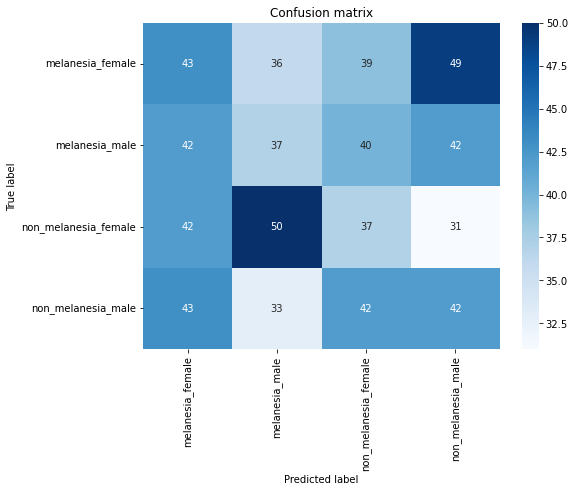

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(train_generator), axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

Saving FB_IMG_1674738953156.jpg to FB_IMG_1674738953156.jpg
1/1 [==============================] - 0s 260ms/step
0
melanesia_female


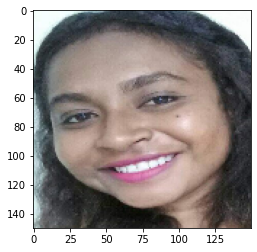

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
 
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  output_class = np.argmax(classes)
  print(output_class)
  if output_class==0:
    print('melanesia_female')
  elif output_class==1:
    print('melanesia_male')
  elif output_class==2:
    print('non_melanesia_female')
  elif output_class==3:
    print('non_melanesia_male')

In [ ]:
model.save("4gendervgg16.h5")